## Modelagem - Predição da produtividade da cana-de-açúcar

Nesta série de scripts iremos começar o processo de modelagem. O método que mais se aplica ao nosso conjunto de dados é a análise de dados em painel, que é um tipo de regressão linear, que considera os efeitos dos indivíduos e do tempo, na forma de séries temporais. Aqui iremos aplicar a análise em painel primeiro. Usei o exemplo desse [link](https://bashtage.github.io/linearmodels/panel/examples/examples.html).

Seguidamente, também utilizaremos machine learning. Aqui eu testei o gradient boosting e random forest. Fiz uma grid search básico para procurar os melhores parametros do modelo e escolhi o gradient boosting para continuar. Para este modelo, também utilizei o Shapley values (teoria de jogos) para entender quais variavéis foram mais importantes para explicar a produtividade da cana-de-açúcar. 

Links:
1. [A Guide to Panel Data Regression: Theoretics and Implementation with Python](https://towardsdatascience.com/a-guide-to-panel-data-regression-theoretics-and-implementation-with-python-4c84c5055cf8)

### Parte 1: Panel data

#### 1.1. Todos os municípios

In [1]:
# Carregar librarias
import pandas as pd
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy import stats
from pprint import pprint
from sklearn import metrics
from linearmodels import PanelOLS
from sklearn.metrics import mean_squared_error, r2_score
from linearmodels.panel import PooledOLS, RandomEffects, BetweenOLS, compare
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Carregar dataset dos anos 2000-2014
data_sugarcane = pd.read_csv("tables/new_data_all_2000-2014.csv", sep =  ';').drop(['AP'], axis = 1)

In [3]:
# Visão dos dados
data_sugarcane.head()

,CD_MUN,MUN,Year,Yield,AC,QP,VP,AET,NDVI,NPP,SOIL,TMIN,TMMX,PR,LST
0,3500105,Adamantina (SP),2000,50000.0,7000.0,350000.0,6244.0,704,5174.465583,4047,165.814275,163,288,91,15244
1,3500204,Adolfo (SP),2000,NaN,NaN,NaN,NaN,716,4079.833442,5245,255.016962,162,290,94,15090
2,3500303,Aguaí (SP),2000,80000.0,5250.0,420000.0,7493.0,675,5613.906725,8672,398.974009,151,272,109,15133
3,3500550,Águas de Santa Bárbara (SP),2000,NaN,NaN,NaN,NaN,776,5388.291761,8146,245.525207,142,270,95,15148
4,3500709,Agudos (SP),2000,70000.0,8000.0,560000.0,9990.0,746,5968.640067,9080,247.830150,146,274,94,15097


In [12]:
# Correlação
data_sugarcane.corr()

,CD_MUN,Year,Yield,AC,QP,VP,AET,NDVI,NPP,SOIL,TMIN,TMMX,PR,LST
CD_MUN,1.000000,0.002921,-0.007790,-0.007457,-0.012258,-0.009925,0.033056,-0.009682,-0.051804,0.014942,0.076323,0.065672,0.023900,0.040368
Year,0.002921,1.000000,0.026385,0.162405,0.154258,0.322049,0.164508,0.206505,0.293901,0.097727,-0.030514,-0.015904,0.065817,-0.037794
Yield,-0.007790,0.026385,1.000000,0.060631,0.137406,0.094055,-0.049899,-0.170335,-0.156498,-0.087025,0.176712,0.191148,-0.018506,0.179961
AC,-0.007457,0.162405,0.060631,1.000000,0.989394,0.918250,0.063930,-0.081957,-0.074929,0.069299,0.153435,0.127256,0.115300,0.124137
QP,-0.012258,0.154258,0.137406,0.989394,1.000000,0.916068,0.059610,-0.080767,-0.069393,0.083333,0.152291,0.127066,0.133433,0.118427
VP,-0.009925,0.322049,0.094055,0.918250,0.916068,1.000000,0.084436,-0.056281,-0.039617,0.062346,0.154225,0.133526,0.074384,0.125640
AET,0.033056,0.164508,-0.049899,0.063930,0.059610,0.084436,1.000000,0.260367,0.036575,0.191488,-0.036367,0.000510,0.352320,-0.182167
NDVI,-0.009682,0.206505,-0.170335,-0.081957,-0.080767,-0.056281,0.260367,1.000000,0.688284,0.522060,-0.559699,-0.582118,0.418569,-0.664948
NPP,-0.051804,0.293901,-0.156498,-0.074929,-0.069393,-0.039617,0.036575,0.688284,1.000000,0.514485,-0.804777,-0.818580,0.425101,-0.826153
SOIL,0.014942,0.097727,-0.087025,0.069299,0.083333,0.062346,0.191488,0.522060,0.514485,1.000000,-0.406724,-0.426287,0.685095,-0.443756


In [13]:
# Converter o ano para categórico
year_sugar = pd.Categorical(data_sugarcane.Year)

In [14]:
# Criar o index utilizando o ano e o código do municipio
data_sugar = data_sugarcane.set_index(['CD_MUN', 'Year'])
data_sugar['Year'] = year_sugar

In [15]:
# Info
data_sugar.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6653 entries, (3500105, 2000) to (3557303, 2014)
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   MUN     6653 non-null   object  
 1   Yield   6653 non-null   float64 
 2   AC      6653 non-null   float64 
 3   QP      6653 non-null   float64 
 4   VP      6653 non-null   float64 
 5   AET     6653 non-null   int64   
 6   NDVI    6653 non-null   float64 
 7   NPP     6653 non-null   int64   
 8   SOIL    6653 non-null   float64 
 9   TMIN    6653 non-null   int64   
 10  TMMX    6653 non-null   int64   
 11  PR      6653 non-null   int64   
 12  LST     6653 non-null   int64   
 13  Year    6653 non-null   category
dtypes: category(1), float64(6), int64(6), object(1)
memory usage: 723.1+ KB


In [16]:
# Selecionar as variáveis que serão utilizadas na modelagem
exog_vars_sugar = ['AC', 'QP', 'VP', 'AET', 'NDVI', 'SOIL', 'TMIN', 'TMMX', 'PR', 'LST','Year']

In [17]:
# Adicionar a constante
exog_sugar = sm.add_constant(data_sugar[exog_vars_sugar])
exog_sugar.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6653 entries, (3500105, 2000) to (3557303, 2014)
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   const   6653 non-null   float64 
 1   AC      6653 non-null   float64 
 2   QP      6653 non-null   float64 
 3   VP      6653 non-null   float64 
 4   AET     6653 non-null   int64   
 5   NDVI    6653 non-null   float64 
 6   SOIL    6653 non-null   float64 
 7   TMIN    6653 non-null   int64   
 8   TMMX    6653 non-null   int64   
 9   PR      6653 non-null   int64   
 10  LST     6653 non-null   int64   
 11  Year    6653 non-null   category
dtypes: category(1), float64(6), int64(5)
memory usage: 619.1 KB


In [19]:
# Criar e rodar o modelo - Simple OLS
mod_sugar = PooledOLS(data_sugar.Yield, exog_sugar)
pooled_res_sugar = mod_sugar.fit()
#print(pooled_res_sugar)

In [129]:
# Criar e rodar o modelo  - Fixed effects
mod_fixed_sugar = PanelOLS(data_sugar.Yield, exog_sugar) 
fe_res_sugar = mod_fixed_sugar.fit()
#print(fe_res_sugar)

In [20]:
# Criar e rodar o modelo  - Random effects
mod_random_sugar = RandomEffects(data_sugar.Yield, exog_sugar)
re_res_sugar = mod_random_sugar.fit()
print(re_res_sugar)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  Yield   R-squared:                        0.3609
Estimator:              RandomEffects   R-squared (Between):              0.3935
No. Observations:                6653   R-squared (Within):               0.3235
Date:                Thu, Sep 29 2022   R-squared (Overall):              0.3516
Time:                        11:13:26   Log-likelihood                -7.018e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      155.97
Entities:                         485   P-value                           0.0000
Avg Obs:                       13.718   Distribution:                 F(24,6628)
Min Obs:                       7.0000                                           
Max Obs:                       15.000   F-statistic (robust):             135.68
                            

In [ ]:
# Excluir o ano das variavéis
exog_vars_sugar_sem_year = ['AC', 'QP', 'VP', 'AET', 'NDVI', 'SOIL', 'TMIN', 'TMMX', 'PR', 'LST']

In [ ]:
# Adicionar a constante
exog_sem_year = sm.add_constant(data_sugar[exog_vars_sugar_sem_year])

In [133]:
# Criar e rodar o modelo sem o efeito do ano
mod_sem_year = BetweenOLS(data_sugar.Yield, exog_sem_year)
be_res_sugar = mod_sem_year.fit(reweight = True)
#print(be_res_sugar)

In [134]:
# Comparar os modelos
#print(compare({"Pooled": pooled_res_sugar, "Fe": fe_res_sugar, 'RE': re_res_sugar, "BE": be_res_sugar,}))

In [135]:
# Haussman
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b-B).T, la.inv(v_b-v_B).dot(b-B)) 
    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

hausman_results = hausman(fe_res_sugar, re_res_sugar) 
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: -11.985148218314862
degrees of freedom: 25
p-Value: 1.0


Since the p-value is high, the null hypothesis can be accepted. Accordingly, the RE-model seems to be the most suitable.

The null hypothesis states that individual effects are uncorrelated with the other regressors (aka random effects preferred) is rejected.

In [21]:
# Carregar os dados preditos para os outros anos
pred_yield = pd.read_csv('predictions/predicted_2014-2020.csv', sep = ';').drop(['ID'], axis = 1)
pred_yield.head()

,CD_MUN,MUN,Year,Yield,Predicted yield
0,3500105,Adamantina (SP),2015,80000.0,77446.25
1,3500204,Adolfo (SP),2015,70000.0,73213.85
2,3500303,Aguaí (SP),2015,80000.0,74468.28
3,3500550,Águas de Santa Bárbara (SP),2015,90000.0,75792.47
4,3500709,Agudos (SP),2015,64794.0,59973.32


In [29]:
pred_yield.dropna(inplace = True)

In [30]:
# Baseline errors, and display average baseline error
baseline_errors_15_20 = abs(pred_yield['Yield'].mean() - pred_yield['Yield'])
print('Average baseline error: ', round(np.mean(baseline_errors_15_20), 2))

Average baseline error:  8093.33


In [31]:
rmse_pda = float(format(np.sqrt(mean_squared_error(pred_yield['Yield'], pred_yield['Predicted yield'])), '.2f'))
rmse_pda

9157.55

In [46]:
# Agrupar por ano e calcular o desvio padrão
pred_by_year = pd.DataFrame(pred_yield.groupby('Year')['Predicted yield'].mean().reset_index())
pred_by_year['Predicted yield'] = pred_by_year['Predicted yield'].astype(int)
st_pred_yield = pd.DataFrame(pred_yield.groupby('Year')['Predicted yield'].std()).reset_index()
st_pred_yield.rename(columns = {'Predicted yield': 'st_pred_yield'}, inplace = True)
st_pred_yield['st_pred_yield'] = st_pred_yield['st_pred_yield'].astype(int)
new_pred_by_year = pred_by_year.join([st_pred_yield['st_pred_yield']])
new_pred_by_year = new_pred_by_year.astype(int)
new_pred_by_year['Year'] = pd.to_datetime(new_pred_by_year['Year'], format = '%Y')
new_pred_by_year

,Year,Predicted yield,st_pred_yield
0,2015-01-01,73555,7567
1,2016-01-01,75828,7363
2,2017-01-01,76388,8605
3,2018-01-01,76591,7653
4,2019-01-01,78032,7359
5,2020-01-01,78805,7221


In [47]:
# Plots
## Carregar os dados de todos os anos
obs_yield = pd.read_csv("tables/dat_yield_melt_all_years.csv").drop(['Unnamed: 0'], axis = 1)
obs_yield.rename(columns = {'variable': 'Year', 'value': 'Yield'}, inplace = True)
new_by_year = pd.DataFrame(obs_yield.groupby('Year')['Yield'].mean().reset_index())
new_by_year['Yield'] = new_by_year['Yield'].astype(int)
st_yield = pd.DataFrame(obs_yield.groupby('Year')['Yield'].std()).reset_index()
st_yield.rename(columns = {'Yield': 'st_yield'}, inplace = True)
st_yield['st_yield'] = st_yield['st_yield'].astype(int)
new_data_by_year = new_by_year.join([st_yield['st_yield']])
new_data_by_year = new_data_by_year.astype(int)
new_data_by_year['Year'] = pd.to_datetime(new_data_by_year['Year'], format = '%Y')
new_data_by_year

,Year,Yield,st_yield
0,2000-01-01,75980,13483
1,2001-01-01,76309,12431
2,2002-01-01,77228,12757
3,2003-01-01,78786,15468
4,2004-01-01,79715,12006
5,2005-01-01,80696,13380
6,2006-01-01,83491,17777
7,2007-01-01,83649,15362
8,2008-01-01,82926,14588
9,2009-01-01,84098,15308


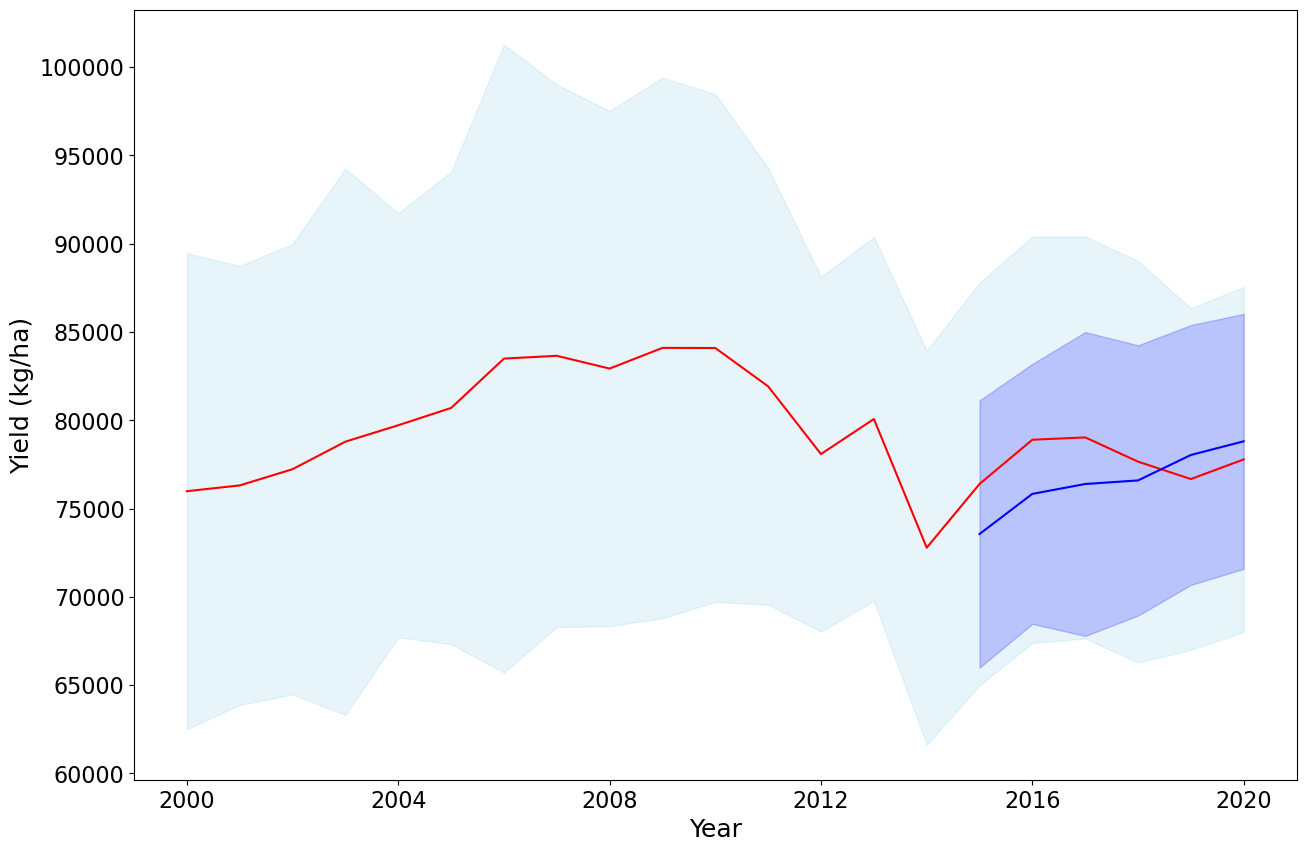

In [48]:
# Plots
plt.figure(figsize = (15,10))
plt.plot(new_data_by_year['Year'], new_data_by_year['Yield'], color = 'red', label='observed')
plt.fill_between(new_data_by_year['Year'], (new_data_by_year['Yield'] + new_data_by_year['st_yield']), 
                 (new_data_by_year['Yield'] - new_data_by_year['st_yield']), alpha = 0.2, color = 'skyblue')
plt.plot(new_pred_by_year['Year'], new_pred_by_year['Predicted yield'], color = 'blue', label = 'predicted')
plt.fill_between(new_pred_by_year['Year'], (new_pred_by_year['Predicted yield'] + new_pred_by_year['st_pred_yield']), 
                (new_pred_by_year['Predicted yield'] - new_pred_by_year['st_pred_yield']), alpha = 0.2, color = 'blue')
plt.ylabel('Yield (kg/ha)', fontsize = 18)
plt.tick_params(labelsize=16)
plt.xlabel('Year', fontsize = 18)
#plt.savefig("predicted_yield_over_time.jpeg", dpi = 300)
plt.show()

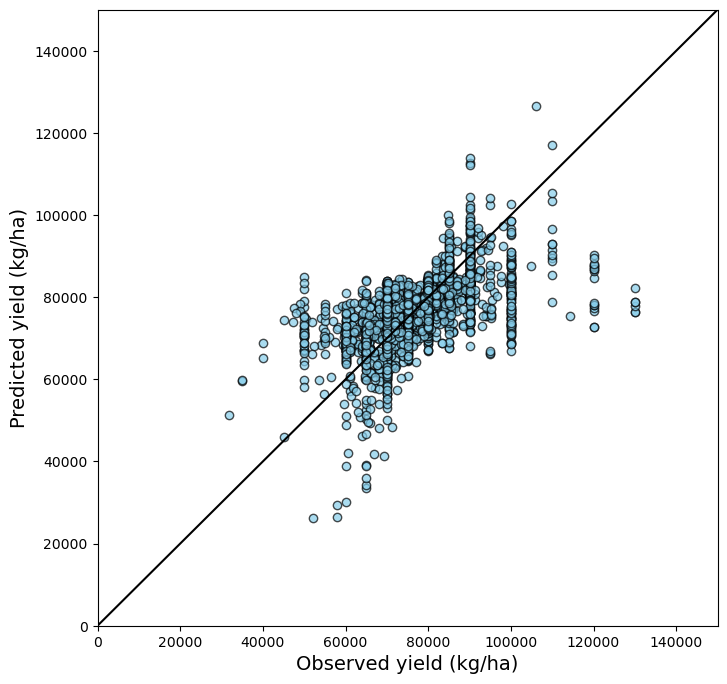

In [49]:
# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax = plt.gca()
ax.set_ylim([0, 150000])
ax.set_xlim([0, 150000])
ax.scatter(pred_yield['Yield'], pred_yield['Predicted yield'], edgecolor='k', facecolor='skyblue', alpha=0.7)
ax.axline((0, 1), slope=1, color='black', label='by slope')
ax.set_ylabel('Predicted yield (kg/ha)', fontsize=14)
ax.set_xlabel('Observed yield (kg/ha)', fontsize=14)
#ax.set_title('$R^2= %.2f$' % r2, fontsize=18)
#plt.savefig('predicted_vs_observed_2015-2020.jpeg', dpi = 300)
plt.show()

#### 1.2. Predição por quantil

In [50]:
# Carregar dataset dos anos 2000-2014 - Quantiles
sugar_quantil = pd.read_csv("tables/new_data_quantiles.csv", sep =  ',').drop(['AP', 'Unnamed: 0'], axis = 1)
sugar_quantil.rename(columns = {'variable': 'Year', 'value':'Yield'}, inplace = True)
sugar_quantil['quantiles_yield']  = sugar_quantil['quantiles_yield'].astype('string')

In [51]:
# Separar os quantis dos anos 2015-2020
sugar_quantil_train = sugar_quantil.iloc[:75]
sugar_quantil_test = sugar_quantil.iloc[76:]
#sugar_quantil_test.to_csv("dat_quantil_2015-2020.csv")

In [52]:
# Correlação
sugar_quantil_train.corr()

,Year,Yield,AC,QP,VP,AET,NDVI,NPP,SOIL,TMIN,TMMX,PR,LST
Year,1.000000,0.052760,0.577530,0.526525,0.795585,0.191420,0.493974,0.621905,0.358284,-0.123830,-0.117373,0.155871,-0.169839
Yield,0.052760,1.000000,0.405937,0.565217,0.279845,-0.128495,-0.318165,-0.160830,0.020931,0.398633,0.485417,0.141804,0.320614
AC,0.577530,0.405937,1.000000,0.978083,0.892924,0.140956,-0.009460,0.044718,0.173634,0.284202,0.347578,0.118922,0.298583
QP,0.526525,0.565217,0.978083,1.000000,0.852929,0.117504,-0.043717,0.042913,0.201653,0.305215,0.376882,0.184638,0.287415
VP,0.795585,0.279845,0.892924,0.852929,1.000000,0.153334,0.156514,0.218530,0.219045,0.223012,0.262217,0.054628,0.201274
AET,0.191420,-0.128495,0.140956,0.117504,0.153334,1.000000,0.633598,0.057091,0.540067,-0.163745,-0.184927,0.509081,-0.344970
NDVI,0.493974,-0.318165,-0.009460,-0.043717,0.156514,0.633598,1.000000,0.604742,0.676253,-0.472073,-0.510452,0.346864,-0.773900
NPP,0.621905,-0.160830,0.044718,0.042913,0.218530,0.057091,0.604742,1.000000,0.397775,-0.701540,-0.695899,0.263595,-0.752440
SOIL,0.358284,0.020931,0.173634,0.201653,0.219045,0.540067,0.676253,0.397775,1.000000,-0.397049,-0.401470,0.546748,-0.528475
TMIN,-0.123830,0.398633,0.284202,0.305215,0.223012,-0.163745,-0.472073,-0.701540,-0.397049,1.000000,0.982191,-0.175757,0.786601


In [53]:
# Converter o ano para categórico
year_sugar = pd.Categorical(sugar_quantil_train.Year)

In [54]:
# Criar o index utilizando o ano e o código do municipio
sugar_quantil_train_new = sugar_quantil_train.set_index(['quantiles_yield', 'Year'])
sugar_quantil_train_new['Year'] = year_sugar
sugar_quantil_train_new

,,Yield,AC,QP,VP,AET,NDVI,NPP,SOIL,TMIN,TMMX,PR,LST,Year
quantiles_yield,Year,,,,,,,,,,,,,
0,2000,65799.0,3554.0,234130.0,4177.0,724,5604,8286,275,150,270,102,15120,2000
1,2000,73683.0,7822.0,560907.0,10007.0,713,5379,6662,249,156,278,101,15181,2000
2,2000,74812.0,7119.0,542044.0,9670.0,713,5309,6687,277,156,279,102,15185,2000
3,2000,80359.0,8446.0,669874.0,11951.0,700,5286,6800,302,158,280,104,15195,2000
4,2000,86921.0,6659.0,556949.0,9936.0,698,5233,6377,271,158,281,101,15205,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2014,67590.0,6881.0,443992.0,23939.0,753,6081,9500,304,156,276,96,15135,2014
1,2014,70124.0,12296.0,857436.0,46478.0,748,5840,7994,272,162,284,95,15194,2014
2,2014,71563.0,13357.0,933422.0,48736.0,746,5770,7917,303,162,285,96,15198,2014


In [55]:
# Selecionar as variáveis que serão utilizadas na modelagem
exog_quantil = ['AC', 'QP', 'VP', 'AET', 'NDVI', 'SOIL', 'TMIN', 'TMMX', 'PR', 'LST','Year']

In [56]:
# Adicionar a constante
exog_quantil = sm.add_constant(sugar_quantil_train_new[exog_quantil])
exog_quantil.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 75 entries, ('0', 2000) to ('4', 2014)
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   const   75 non-null     float64 
 1   AC      75 non-null     float64 
 2   QP      75 non-null     float64 
 3   VP      75 non-null     float64 
 4   AET     75 non-null     int64   
 5   NDVI    75 non-null     int64   
 6   SOIL    75 non-null     int64   
 7   TMIN    75 non-null     int64   
 8   TMMX    75 non-null     int64   
 9   PR      75 non-null     int64   
 10  LST     75 non-null     int64   
 11  Year    75 non-null     category
dtypes: category(1), float64(4), int64(7)
memory usage: 8.3+ KB


In [57]:
# Criar e rodar o modelo - Simple OLS
pooled_q = PooledOLS(sugar_quantil_train_new.Yield, exog_quantil).fit()
#print(pooled_q)

In [58]:
# Criar e rodar o modelo  - Fixed effects
fixed_q = PanelOLS(sugar_quantil_train_new.Yield, exog_quantil).fit()
print(fixed_q)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  Yield   R-squared:                        0.9721
Estimator:                   PanelOLS   R-squared (Between):              0.9997
No. Observations:                  75   R-squared (Within):               0.8633
Date:                Thu, Sep 29 2022   R-squared (Overall):              0.9721
Time:                        11:31:19   Log-likelihood                   -648.95
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      72.498
Entities:                           5   P-value                           0.0000
Avg Obs:                       15.000   Distribution:                   F(24,50)
Min Obs:                       15.000                                           
Max Obs:                       15.000   F-statistic (robust):             72.498
                            

In [59]:
# Criar e rodar o modelo  - Random effects
random_q = RandomEffects(sugar_quantil_train_new.Yield, exog_quantil).fit()
print(random_q)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  Yield   R-squared:                        0.9721
Estimator:              RandomEffects   R-squared (Between):              0.9997
No. Observations:                  75   R-squared (Within):               0.8633
Date:                Thu, Sep 29 2022   R-squared (Overall):              0.9721
Time:                        11:31:22   Log-likelihood                   -648.95
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      72.498
Entities:                           5   P-value                           0.0000
Avg Obs:                       15.000   Distribution:                   F(24,50)
Min Obs:                       15.000                                           
Max Obs:                       15.000   F-statistic (robust):             72.498
                            

In [ ]:
# Haussman
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b-B).T, la.inv(v_b-v_B).dot(b-B)) 
    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

hausman_results = hausman(fixed_q, random_q) 
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

In [60]:
# Carregar os dados preditos para os outros anos
pred_yield_q = pd.read_csv('predictions/predicted_2015-2020_quantiles.csv', sep = ';').drop(['ID'], axis = 1)
pred_yield_q.head()

,quantiles_yield,Year,Yield,AC,QP,VP,AET,NDVI,NPP,SOIL,TMIN,TMMX,PR,LST,Pred_yield
0,1,2015,73000,11860,870471,45957,855,6322,8770,354,163,284,137,15139,68221.6005
1,2,2015,75295,13432,1008805,53045,859,6298,8733,383,162,286,137,15143,66557.2679
2,3,2015,79202,15066,1194047,64608,847,6207,8434,388,164,286,136,15165,69261.2537
3,4,2015,83597,10359,850024,45824,844,6256,8516,370,164,287,133,15159,78652.6558
4,0,2016,70658,6675,472945,30320,809,6103,10779,374,150,271,119,15086,53883.9825


In [61]:
# Baseline errors, and display average baseline error
baseline_errors_15_20_q = abs(pred_yield_q['Yield'].mean() - pred_yield_q['Pred_yield'])
print('Average baseline error: ', round(np.mean(baseline_errors_15_20_q), 2))

Average baseline error:  15389.46


In [62]:
rmse_quantile = float(format(np.sqrt(mean_squared_error(pred_yield_q['Yield'], pred_yield_q['Pred_yield'])), '.2f'))
rmse_quantile

17020.19

In [63]:
# Agrupar por ano e calcular o desvio padrão
pred_by_year_q = pd.DataFrame(pred_yield_q.groupby('Year')['Pred_yield'].mean().reset_index())
pred_by_year_q['Pred_yield'] = pred_by_year_q['Pred_yield'].astype(int)
st_pred_yield_q = pd.DataFrame(pred_yield_q.groupby('Year')['Pred_yield'].std()).reset_index()
st_pred_yield_q.rename(columns = {'Pred_yield': 'st_pred_yield'}, inplace = True)
st_pred_yield_q['st_pred_yield'] = st_pred_yield_q['st_pred_yield'].astype(int)
new_pred_by_year_q = pred_by_year_q.join([st_pred_yield_q['st_pred_yield']])
new_pred_by_year_q = new_pred_by_year_q.astype(int)
new_pred_by_year_q['Year'] = pd.to_datetime(new_pred_by_year_q['Year'], format = '%Y')
new_pred_by_year_q

,Year,Pred_yield,st_pred_yield
0,2015-01-01,70673,5434
1,2016-01-01,61731,7839
2,2017-01-01,60531,8277
3,2018-01-01,63299,6896
4,2019-01-01,72670,6221
5,2020-01-01,50319,5981


In [64]:
# Plots
## Carregar os dados de todos os anos
obs_yield = pd.read_csv("tables/dat_yield_melt_all_years.csv").drop(['Unnamed: 0'], axis = 1)
obs_yield.rename(columns = {'variable': 'Year', 'value': 'Yield'}, inplace = True)
obs_by_year = pd.DataFrame(obs_yield.groupby('Year')['Yield'].mean().reset_index())
obs_by_year['Yield'] = obs_by_year['Yield'].astype(int)
st_yield_obs = pd.DataFrame(obs_yield.groupby('Year')['Yield'].std()).reset_index()
st_yield_obs.rename(columns = {'Yield': 'st_yield'}, inplace = True)
st_yield_obs['st_yield'] = st_yield_obs['st_yield'].astype(int)
new_data_by_year = obs_by_year.join([st_yield_obs['st_yield']])
new_data_by_year = new_data_by_year.astype(int)
new_data_by_year['Year'] = pd.to_datetime(new_data_by_year['Year'], format = '%Y')
new_data_by_year

,Year,Yield,st_yield
0,2000-01-01,75980,13483
1,2001-01-01,76309,12431
2,2002-01-01,77228,12757
3,2003-01-01,78786,15468
4,2004-01-01,79715,12006
5,2005-01-01,80696,13380
6,2006-01-01,83491,17777
7,2007-01-01,83649,15362
8,2008-01-01,82926,14588
9,2009-01-01,84098,15308


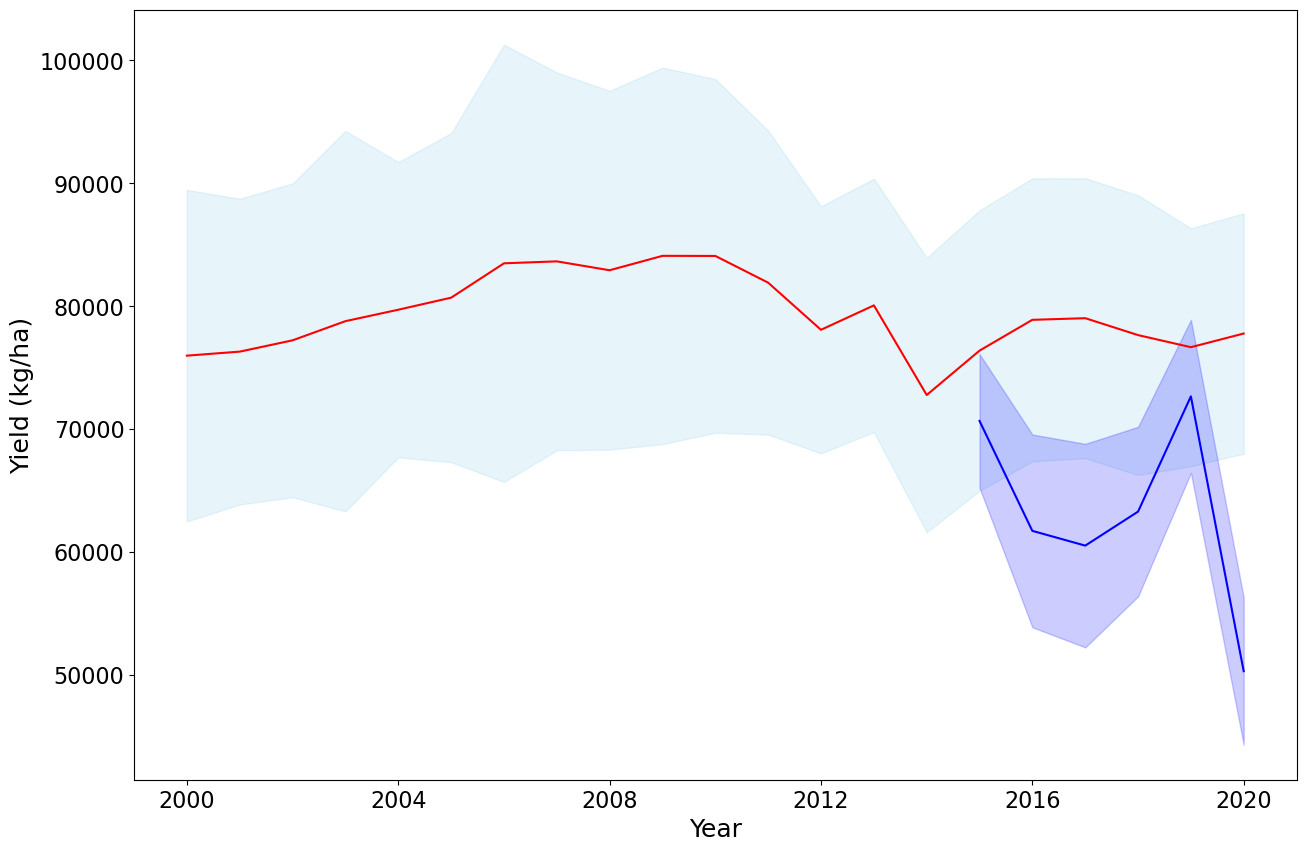

In [65]:
# Plots
plt.figure(figsize = (15,10))
plt.plot(new_data_by_year['Year'], new_data_by_year['Yield'], color = 'red', label='observed')
plt.fill_between(new_data_by_year['Year'], (new_data_by_year['Yield'] + new_data_by_year['st_yield']), 
                 (new_data_by_year['Yield'] - new_data_by_year['st_yield']), alpha = 0.2, color = 'skyblue')
plt.plot(new_pred_by_year_q['Year'], new_pred_by_year_q['Pred_yield'], color = 'blue', label = 'predicted')
plt.fill_between(new_pred_by_year_q['Year'], (new_pred_by_year_q['Pred_yield'] + new_pred_by_year_q['st_pred_yield']), 
                (new_pred_by_year_q['Pred_yield'] - new_pred_by_year_q['st_pred_yield']), alpha = 0.2, color = 'blue')
plt.ylabel('Yield (kg/ha)', fontsize = 18)
plt.tick_params(labelsize=16)
plt.xlabel('Year', fontsize = 18)
#plt.savefig("predicted_yield_over_time_quantiles.jpeg", dpi = 300)
plt.show()

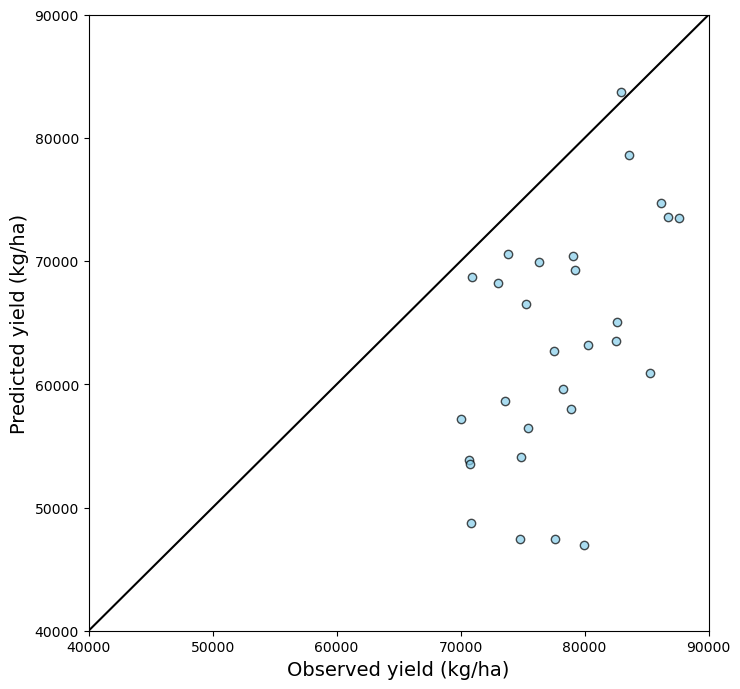

In [66]:
# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax = plt.gca()
ax.set_ylim([40000, 90000])
ax.set_xlim([40000, 90000])
ax.scatter(pred_yield_q['Yield'], pred_yield_q['Pred_yield'], edgecolor='k', facecolor='skyblue', alpha=0.7)
ax.axline((0, 1), slope=1, color='black', label='by slope')
ax.set_ylabel('Predicted yield (kg/ha)', fontsize=14)
ax.set_xlabel('Observed yield (kg/ha)', fontsize=14)
#ax.set_title('$R^2= %.2f$' % r2, fontsize=18)
plt.savefig('predicted_vs_observed_2015-2020_quantiles.jpeg', dpi = 300)
plt.show()

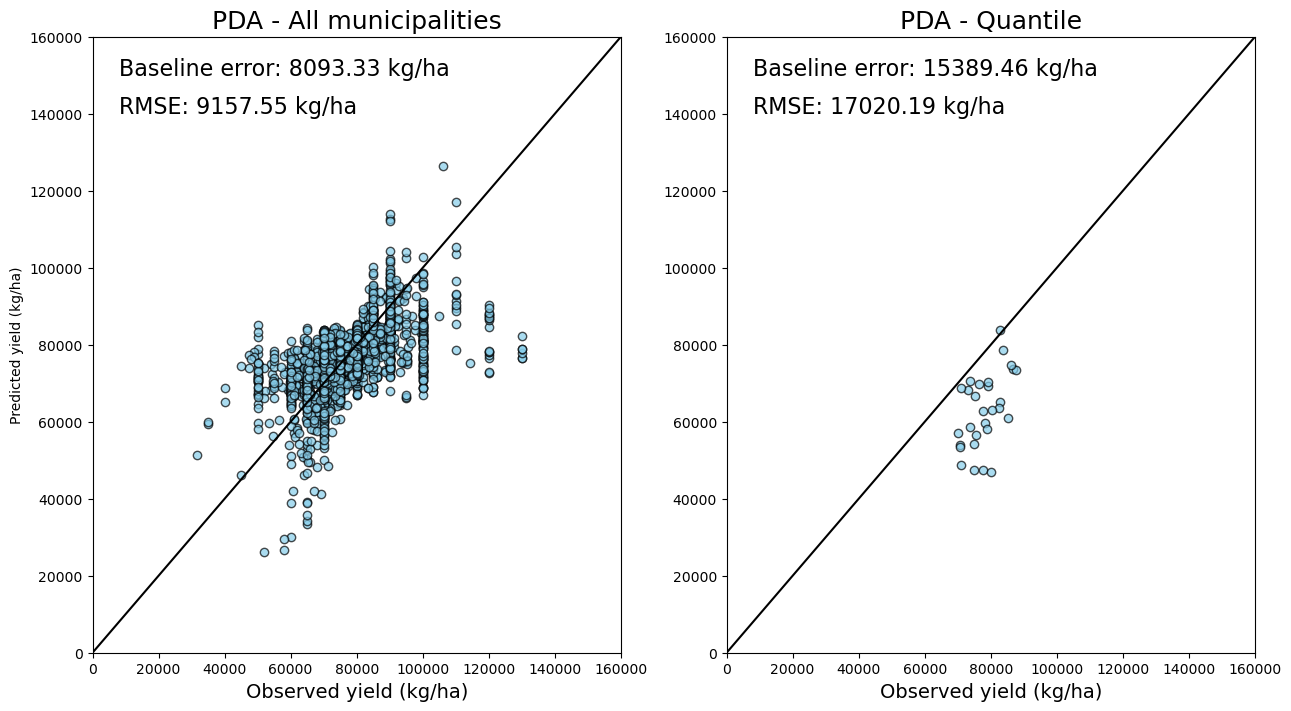

In [71]:
## Juntar as figuas
# Plot
plt.figure(figsize=(15, 8))


plt.subplot(1,2,1)
ax = plt.gca()
ax.set_ylim([0, 160000])
ax.set_xlim([0, 160000])
plt.scatter(pred_yield['Yield'], pred_yield['Predicted yield'], edgecolor='k', facecolor='skyblue', alpha=0.7)
ax.axline((0, 1), slope=1, color='black', label='by slope')
plt.text(8000, 150000, 'Baseline error: 8093.33 kg/ha', fontsize = 16)
plt.text(8000, 140000, 'RMSE: 9157.55 kg/ha', fontsize = 16)
plt.ylabel('')
plt.xlabel('Observed yield (kg/ha)', fontsize=14)
plt.ylabel('Predicted yield (kg/ha)')
plt.title('PDA - All municipalities', fontsize=18)

plt.subplot(1,2,2)
ax = plt.gca()
ax.set_ylim([0, 160000])
ax.set_xlim([0, 160000])
plt.scatter(pred_yield_q['Yield'], pred_yield_q['Pred_yield'], edgecolor='k', facecolor='skyblue', alpha=0.7)
ax.axline((0, 1), slope=1, color='black', label='by slope')
plt.text(8000, 150000, 'Baseline error: 15389.46 kg/ha', fontsize = 16)
plt.text(8000, 140000, 'RMSE: 17020.19 kg/ha', fontsize = 16)
plt.ylabel('')
plt.xlabel('Observed yield (kg/ha)', fontsize=14)
plt.title('PDA - Quantile', fontsize=18)

plt.savefig('predicted_vs_observed_2015-2020_pda.jpeg', dpi = 300)
plt.show()

## Machine learning

In [72]:
# Remove NAs
data_sugarcane.dropna(subset = 'Yield', inplace = True)
data_sugarcane.head()

,CD_MUN,MUN,Year,Yield,AC,QP,VP,AET,NDVI,NPP,SOIL,TMIN,TMMX,PR,LST
0,3500105,Adamantina (SP),2000,50000.0,7000.0,350000.0,6244.0,704,5174.465583,4047,165.814275,163,288,91,15244
2,3500303,Aguaí (SP),2000,80000.0,5250.0,420000.0,7493.0,675,5613.906725,8672,398.974009,151,272,109,15133
4,3500709,Agudos (SP),2000,70000.0,8000.0,560000.0,9990.0,746,5968.640067,9080,247.830150,146,274,94,15097
6,3500907,Altair (SP),2000,75000.0,6000.0,450000.0,8028.0,686,5609.467113,5608,412.288194,168,297,107,15220
7,3501004,Altinópolis (SP),2000,70000.0,10000.0,700000.0,12488.0,681,5739.925326,8993,410.676864,154,268,123,15175


In [123]:
# Split the dataset into X and Y -- Convert to z-score
x = data_sugarcane[['MUN', 'AC','QP','VP' ,'AET', 'SOIL', 'NDVI','TMIN', 'TMMX', 'PR', 'LST', 'NPP']]
x = x.set_index('MUN')
#x_zscore = x.apply(stats.zscore)
y = data_sugarcane['Yield']

In [124]:
x

,AC,QP,VP,AET,SOIL,NDVI,TMIN,TMMX,PR,LST,NPP
MUN,,,,,,,,,,,
Adamantina (SP),7000.0,350000.0,6244.0,704,165.814275,5174.465583,163,288,91,15244,4047
Aguaí (SP),5250.0,420000.0,7493.0,675,398.974009,5613.906725,151,272,109,15133,8672
Agudos (SP),8000.0,560000.0,9990.0,746,247.830150,5968.640067,146,274,94,15097,9080
Altair (SP),6000.0,450000.0,8028.0,686,412.288194,5609.467113,168,297,107,15220,5608
Altinópolis (SP),10000.0,700000.0,12488.0,681,410.676864,5739.925326,154,268,123,15175,8993
...,...,...,...,...,...,...,...,...,...,...,...
Vitória Brasil (SP),450.0,40500.0,2105.0,715,333.110063,5585.656276,166,294,91,15321,6418
Votuporanga (SP),8387.0,587090.0,36987.0,739,318.736667,5642.405411,170,299,95,15278,6471
Zacarias (SP),8238.0,576660.0,28412.0,729,275.759016,4936.442236,167,295,90,15127,6392


In [125]:
# Split dataset into training and validation
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 672, test_size = 0.30)

In [126]:
# Baseline errors, and display average baseline error
baseline_errors = abs(y_test.mean() - y_test)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  9569.7


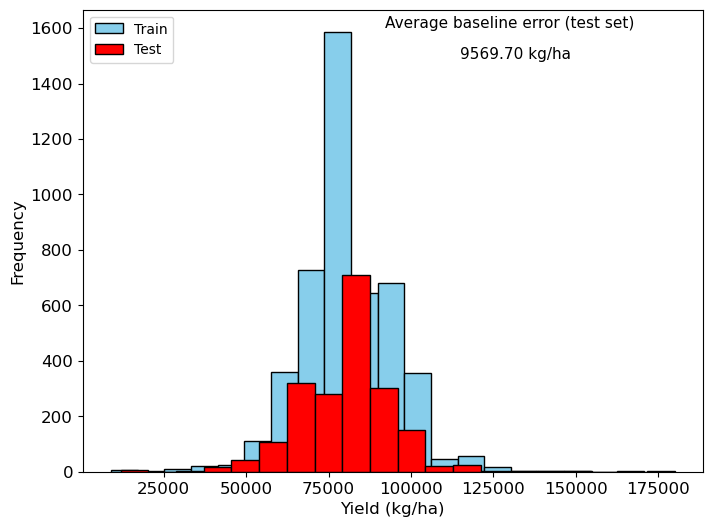

In [76]:
# Plot train and test datasets
plt.subplots(figsize=(8, 6))
plt.hist(y_train, bins = 20, ec = 'black', color = 'skyblue', label = 'Train')
plt.hist(y_test, bins = 20, ec = 'black', color ='red', label = 'Test')
plt.legend(loc='upper left')
plt.xlabel('Yield (kg/ha)', fontsize = 12)
plt.tick_params(labelsize=12)
plt.ylabel('Frequency', fontsize = 12)
plt.text(92000, 1600, 'Average baseline error (test set)', fontsize = 11)
plt.text(115000, 1490, '9569.70 kg/ha', fontsize = 11)
plt.savefig("hist_train_test.jpeg", dpi = 300)
plt.show()

In [127]:
# Gradient Boosting - Base model, no hyperparameter tuning
base_gb = GradientBoostingRegressor().fit(x_train, y_train)
print('The R2 of the train is {}'.format(round(base_gb.score(x_train, y_train), 2)))
print('The R2 of the test is {}'.format(round(base_gb.score(x_test, y_test), 2)))

The R2 of the train is 0.7
The R2 of the test is 0.6


In [128]:
# Random Forest - Base model, no hyperparameter tuning
base_rf = RandomForestRegressor().fit(x_train, y_train)
print('The R2 of the train is {}'.format(round(base_rf.score(x_train, y_train), 2)))
print('The R2 of the test is {}'.format(round(base_rf.score(x_test, y_test), 2)))

The R2 of the train is 0.95
The R2 of the test is 0.62


In [129]:
# Predict using Gradient boosting and RF
base_pred_gb = base_gb.predict(x_test)
base_pred_rf = base_rf.predict(x_test)

In [130]:
# Evaluate the models
def eval_model(model_gb, model_rf, features, target):
    preds_gb = model_gb.predict(features)
    preds_rf = model_rf.predict(features)
    rmse_gb = float(format(np.sqrt(mean_squared_error(target, preds_gb)), '.2f'))
    rmse_rf = float(format(np.sqrt(mean_squared_error(target, preds_rf)), '.2f'))
    print ('\nPerformances')
    print('RMSE Gradient Boosting = ', rmse_gb, 'g/kg')
    print('RMSE Random Forest = ', rmse_rf, 'g/kg')

# Base GB model
eval_model(base_gb, base_rf, x_test, y_test)


Performances
RMSE Gradient Boosting =  8760.19 g/kg
RMSE Random Forest =  8528.28 g/kg


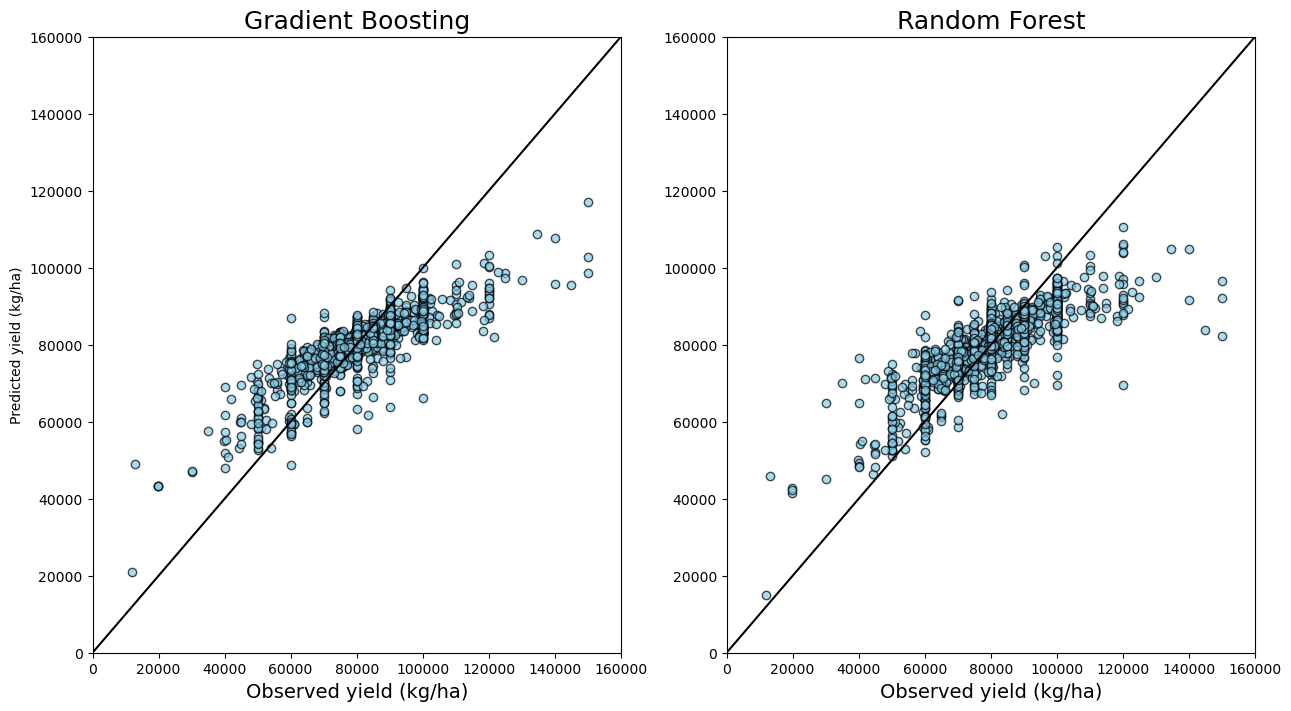

In [131]:
# Plot
plt.figure(figsize=(15, 8))


plt.subplot(1,2,1)
ax = plt.gca()
ax.set_ylim([0, 160000])
ax.set_xlim([0, 160000])
plt.scatter(y_test, base_pred_gb, edgecolor='k', facecolor='skyblue', alpha=0.7)
ax.axline((0, 1), slope=1, color='black', label='by slope')
plt.ylabel('')
plt.xlabel('Observed yield (kg/ha)', fontsize=14)
plt.ylabel('Predicted yield (kg/ha)')
plt.title('Gradient Boosting', fontsize=18)

plt.subplot(1,2,2)
ax = plt.gca()
ax.set_ylim([0, 160000])
ax.set_xlim([0, 160000])
ax.axline((0, 1), slope=1, color='black', label='by slope')
plt.scatter(y_test, base_pred_rf, edgecolor='k', facecolor='skyblue', alpha=0.7)
plt.ylabel('')
plt.xlabel('Observed yield (kg/ha)', fontsize=14)
r2_lr = 0.77
plt.title('Random Forest', fontsize=18)

#plt.savefig('predicted_vs_observed_2015-2020_gb_rf.jpeg', dpi = 300)
plt.show()

### Hyperparameter tuning  -- Gradient Boosting

In [132]:
# Parameters of base models
print('\nParameters currently in use in GB:\n')
pprint(base_gb.get_params())


Parameters currently in use in GB:

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [133]:
# Number of trees
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

# Loss
loss = ['squared_error', 'absolute_error', 'huber']

# Learning rate
learning_rate = [0.05, 0.1, 0.2, 0.5]

# Samples split
min_samples_split = [2, 4, 8, 12, 20, 50, 80]

# Samples leaf
min_samples_leaf = [2, 4, 6, 8, 10, 20, 30, 50, 100]

# Depth
max_depth = [2, 4, 6, 8, 12, 15, 20]

# Max features
max_features = ['auto', 'sqrt', 'log2']

# Max nodes
max_leaf_nodes = [2, 6, 10, 15, 20]

# Create the random grid
random_search_gb = {'n_estimators': n_estimators,
                    'loss': loss,
                    'learning_rate': learning_rate,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'max_depth': max_depth,
                    'max_leaf_nodes': max_leaf_nodes,
                    'max_features': max_features}
random_search_gb

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'loss': ['squared_error', 'absolute_error', 'huber'],
 'learning_rate': [0.05, 0.1, 0.2, 0.5],
 'min_samples_split': [2, 4, 8, 12, 20, 50, 80],
 'min_samples_leaf': [2, 4, 6, 8, 10, 20, 30, 50, 100],
 'max_depth': [2, 4, 6, 8, 12, 15, 20],
 'max_leaf_nodes': [2, 6, 10, 15, 20],
 'max_features': ['auto', 'sqrt', 'log2']}

In [84]:
## Run the model with the hyperparameter tuning
gb_tuning = GradientBoostingRegressor()

gb_tuning_RSCV = RandomizedSearchCV(estimator = gb_tuning, 
                                    param_distributions = random_search_gb, 
                                    n_iter = 10, 
                                    cv = 10, 
                                    verbose = 2, 
                                    n_jobs = -1)

gb_tuning_RSCV.fit(x_train, y_train)

## Print the best parameters
print('\nThe best parameters are: \n')
pprint(gb_tuning_RSCV.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits

The best parameters are: 

{'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 15,
 'max_features': 'auto',
 'max_leaf_nodes': 6,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 400}


In [134]:
## Set cross-validation parameters
gb_grid_params = {'learning_rate': [0.2], 
                  'loss': ['huber'], 
                  'n_estimators': [700],
                  'min_samples_split': [8], 
                  'min_samples_leaf': [10], 
                  'max_features': ['auto'], 
                  'max_depth': [20],
                  'max_leaf_nodes': [10]}

gb_grid = GradientBoostingRegressor()
grid_search_gb = GridSearchCV(estimator = gb_grid, 
                           param_grid = gb_grid_params, 
                           cv = 10, 
                           n_jobs = -1, 
                           verbose = 2)

In [135]:
# Fit grid search
grid_search_gb.fit(x_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.2], 'loss': ['huber'],
                         'max_depth': [20], 'max_features': ['auto'],
                         'max_leaf_nodes': [10], 'min_samples_leaf': [10],
                         'min_samples_split': [8], 'n_estimators': [700]},
             verbose=2)

In [136]:
# Best parameters
grid_search_gb.best_params_

{'learning_rate': 0.2,
 'loss': 'huber',
 'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 8,
 'n_estimators': 700}

In [88]:
best_grid_gb = grid_search_gb.best_estimator_
gb_grid_acc = eval_model(best_grid_gb, best_grid_gb, x_test, y_test)
gb_grid_acc


Performances
RMSE Gradient Boosting =  3618.82 g/kg
RMSE Random Forest =  3618.82 g/kg


In [137]:
# Predict onto the test set
pred_grid_gb = best_grid_gb.predict(x_test)

In [138]:
# Scores
rmse_gb = float(format(np.sqrt(mean_squared_error(y_test, pred_grid_gb)), '.3f'))
print ('\nPerformance')
print('RMSE = ', rmse_gb, 'g/kg')

print('R2 = {}'.format(round(best_grid_gb.score(x_test, y_test), 2)))


Performance
RMSE =  3618.825 g/kg
R2 = 0.93


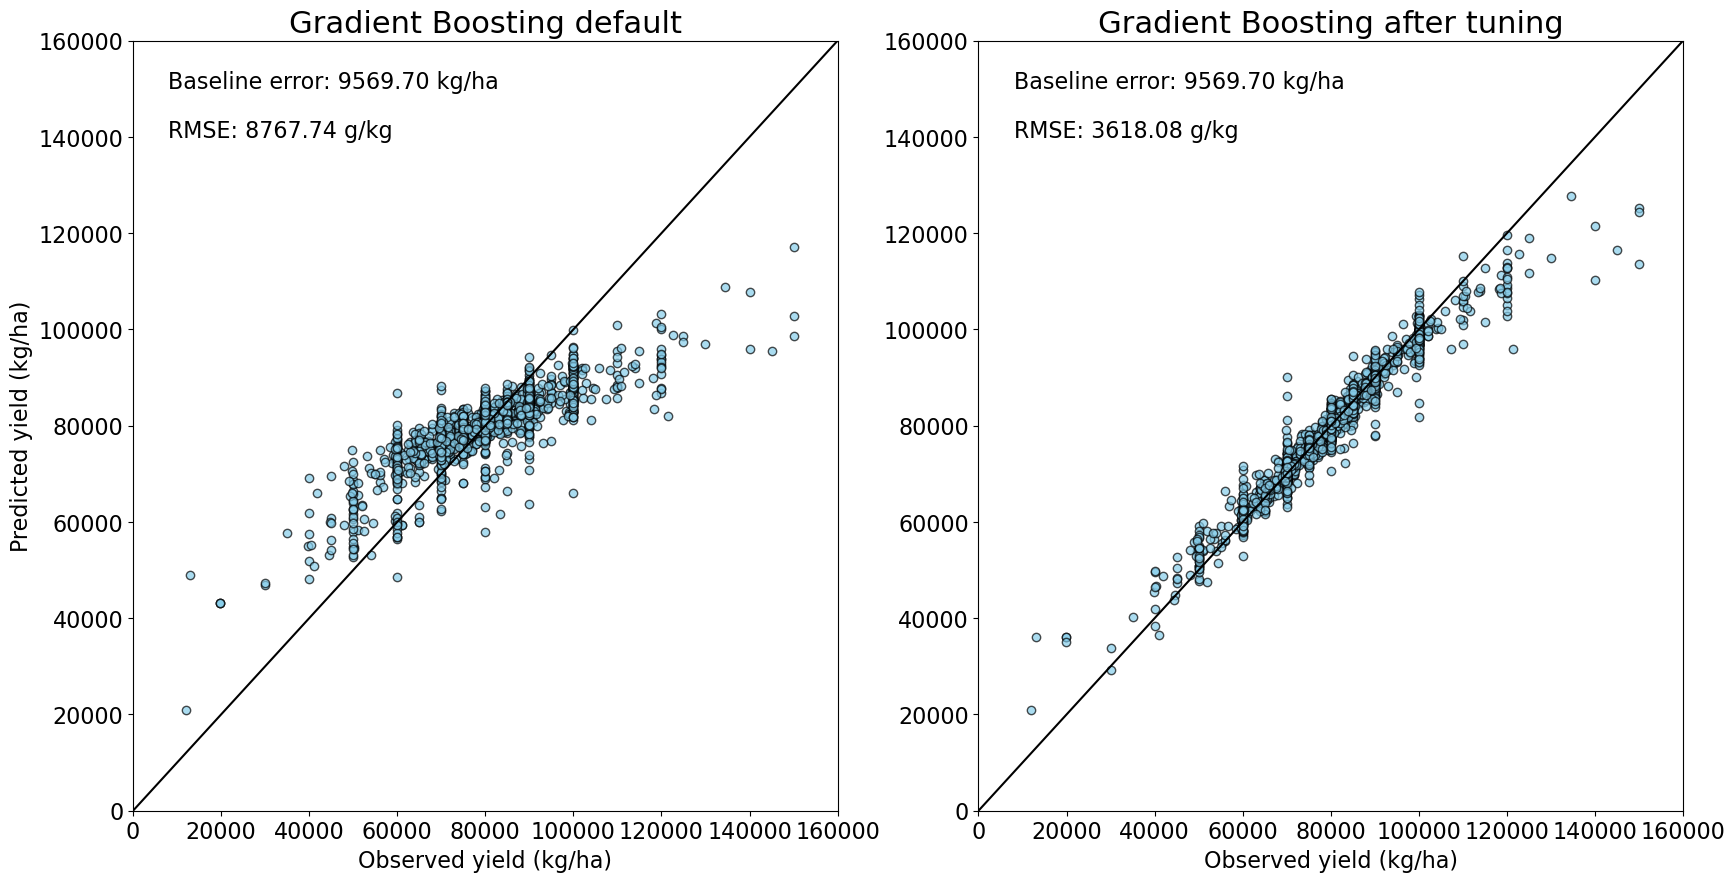

In [139]:
# Plot observed vs predicted
# Plot
plt.figure(figsize=(20, 10))

plt.subplot(1,2,1)
ax = plt.gca()
ax.set_ylim([0, 160000])
ax.set_xlim([0, 160000])
plt.scatter(y_test, base_pred_gb, edgecolor='k', facecolor='skyblue', alpha=0.7)
ax.axline((0, 1), slope=1, color='black', label='by slope')
plt.text(8000, 150000 , 'Baseline error: 9569.70 kg/ha', fontsize = 16)
plt.text(8000, 140000,  'RMSE: 8767.74 g/kg', fontsize = 16)
plt.tick_params(labelsize=16)
plt.xlabel('Observed yield (kg/ha)', fontsize=16)
plt.ylabel('Predicted yield (kg/ha)', fontsize=16)
plt.title('Gradient Boosting default', fontsize=22)

plt.subplot(1,2,2)
ax = plt.gca()
ax.set_ylim([0, 160000])
ax.set_xlim([0, 160000])
plt.scatter(y_test, pred_grid_gb, edgecolor='k', facecolor='skyblue', alpha=0.7)
ax.axline((0, 1), slope=1, color='black', label='by slope')
plt.text(8000, 150000, 'Baseline error: 9569.70 kg/ha', fontsize = 16)
plt.text(8000, 140000, 'RMSE: 3618.08 g/kg', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylabel('')
plt.xlabel('Observed yield (kg/ha)', fontsize=16)
plt.title('Gradient Boosting after tuning', fontsize=22)
#plt.savefig('pred_vs_obs_2015-2020_gb_default_params.jpeg', dpi = 400)
plt.show()

### Importância das variáveis

In [140]:
# Get numerical feature importances
importance = list(best_grid_gb.feature_importances_)
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(x_train.columns, importance)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: QP                   Importance: 0.524
Variable: AC                   Importance: 0.351
Variable: NPP                  Importance: 0.032
Variable: AET                  Importance: 0.021
Variable: SOIL                 Importance: 0.015
Variable: VP                   Importance: 0.013
Variable: TMIN                 Importance: 0.01
Variable: PR                   Importance: 0.01
Variable: NDVI                 Importance: 0.008
Variable: TMMX                 Importance: 0.007
Variable: LST                  Importance: 0.007


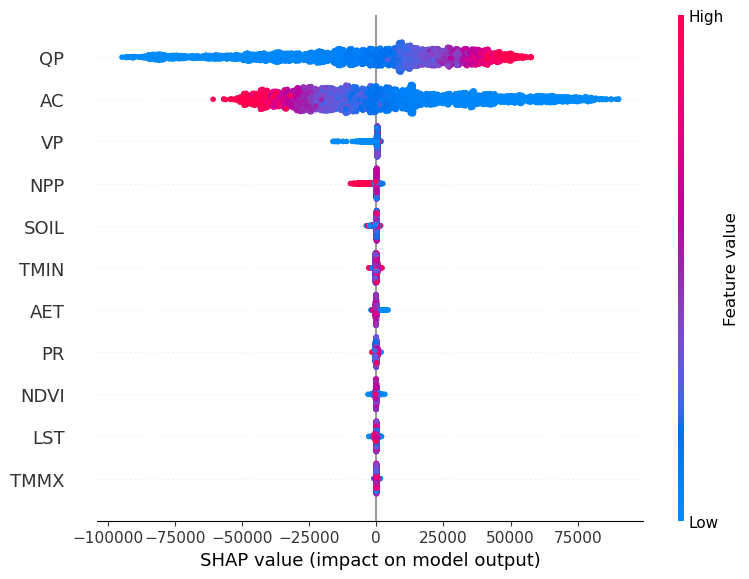

In [141]:
import shap
## Shapley values to explain RF models
explainer = shap.TreeExplainer(best_grid_gb)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, features = x_train, feature_names = x_train.columns)

In [161]:
## Plot the contribution of an individual observation. In this case, the number 17
display(x_train.iloc[2])
shap.initjs()
#i = 11
shap.force_plot(explainer.expected_value, shap_values[3], features=x_train.loc[3], feature_names=x_train.columns, plot_cmap="PkYg")

AC        5000.000000
QP      400000.000000
VP       20000.000000
AET        772.000000
SOIL       246.028158
NDVI      5838.393885
TMIN       156.000000
TMMX       283.000000
PR          98.000000
LST      15175.000000
NPP       7828.000000
Name: Ribeirão do Sul (SP), dtype: float64

KeyError: 3

In [163]:
x_train.loc['Irapuru (SP)']

,AC,QP,VP,AET,SOIL,NDVI,TMIN,TMMX,PR,LST,NPP
MUN,,,,,,,,,,,
Irapuru (SP),7000.0,770000.0,26950.0,788,249.736900,5574.462123,165,290,112,15232,8160
Irapuru (SP),4175.0,250500.0,14820.0,771,221.811135,5709.296374,170,295,91,15280,6407
Irapuru (SP),119.0,13864.0,444.0,815,149.646652,5409.778811,169,293,103,15254,5205
Irapuru (SP),3300.0,247500.0,15221.0,832,328.021470,5861.445035,165,289,105,15207,8235
Irapuru (SP),1155.0,89486.0,2573.0,696,186.036026,5574.125309,171,295,89,15222,5630
Irapuru (SP),8000.0,880000.0,36960.0,688,225.014192,5487.306626,166,290,95,15264,7377
Irapuru (SP),293.0,29300.0,703.0,720,229.148108,5657.135561,167,291,79,15212,5591
Irapuru (SP),5000.0,350000.0,22257.0,713,188.001456,5711.291058,172,296,83,15245,6456
Irapuru (SP),7000.0,770000.0,29861.0,917,336.454512,6279.329220,167,291,118,15155,7964


In [154]:
shap_values[6]

array([-3.67064220e+04,  3.37822266e+04,  7.60344569e+02, -2.76593975e+02,
       -1.29453508e+03, -4.31192059e+01,  8.18414061e+01,  5.22693412e+01,
        1.17970039e+02,  2.74618741e+01,  3.40887255e+01])

### Predição para os anos 2015 - 2020 -- Validação

In [31]:
# Carregar os dados e separar o x do y
dat_2015_2020 = pd.read_csv("dados_all_2015-2020.csv", sep = ';')
dat_2015_2020.dropna(inplace = True)
x_val = dat_2015_2020[['AC','QP','VP' ,'AET', 'SOIL', 'NDVI','TMIN', 'TMMX', 'PR', 'LST', 'NPP']]
y_val = dat_2015_2020['Yield']

In [32]:
x_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2872 entries, 0 to 2909
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AC      2872 non-null   float64
 1   QP      2872 non-null   float64
 2   VP      2872 non-null   float64
 3   AET     2872 non-null   int64  
 4   SOIL    2872 non-null   float64
 5   NDVI    2872 non-null   float64
 6   TMIN    2872 non-null   int64  
 7   TMMX    2872 non-null   int64  
 8   PR      2872 non-null   int64  
 9   LST     2872 non-null   int64  
 10  NPP     2872 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 269.2 KB


In [33]:
# Predezir no conjunto de validação e adicionar ao df do yield
dat_2015_2020['Pred_yieldGB'] = pd.DataFrame(best_grid_gb.predict(x_val))
dat_2015_2020

,ID,CD_MUN,MUN,Year,Yield,AP,AC,QP,VP,AET,NDVI,NPP,SOIL,TMIN,TMMX,PR,LST,Pred_yieldGB
0,1,3500105,Adamantina (SP),2015,80000.0,12950.0,12950.0,1036000.0,61756.0,868,6270.276565,7688,308.184230,169,294,133,15178,79842.398110
1,2,3500204,Adolfo (SP),2015,70000.0,6309.0,6309.0,441630.0,23680.0,885,5062.510928,7706,368.446534,167,295,132,15046,70007.100659
2,3,3500303,Aguaí (SP),2015,80000.0,12500.0,12500.0,1000000.0,53530.0,820,6468.525723,8977,477.758122,158,280,138,15127,80041.717388
3,4,3500550,Águas de Santa Bárbara (SP),2015,90000.0,5500.0,5500.0,495000.0,29700.0,886,6688.432525,10815,401.884688,148,277,138,15030,90685.033785
4,5,3500709,Agudos (SP),2015,64794.0,14632.0,14632.0,948062.0,37069.0,874,7096.525518,10763,349.336278,152,280,134,15013,64760.615433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2905,2906,3556958,Vitória Brasil (SP),2020,100000.0,350.0,350.0,35000.0,2928.0,470,5341.210829,5594,190.666667,169,296,63,15407,NaN
2906,2907,3557105,Votuporanga (SP),2020,70000.0,12100.0,12100.0,847000.0,61831.0,486,5534.181546,5844,210.275741,172,301,65,15352,NaN
2907,2908,3557154,Zacarias (SP),2020,80000.0,8000.0,8000.0,640000.0,51520.0,494,4792.985554,6677,174.659113,168,296,62,15173,NaN
2908,2909,3557204,Chavantes (SP),2020,78960.0,9504.0,9504.0,750436.0,60785.0,609,6121.995311,8975,147.081699,155,281,79,15159,NaN


In [34]:
# Carregar os dados preditos para os outros anos
pred_yield = pd.read_csv('predictions/predicted_2015-2020_GB.csv', sep = ';').drop(['ID'], axis = 1)
pred_yield.head()

,CD_MUN,MUN,Year,Yield,Pred_yieldGB
0,3500105,Adamantina (SP),2015,80000,79842
1,3500204,Adolfo (SP),2015,70000,70007
2,3500303,Aguaí (SP),2015,80000,80042
3,3500550,Águas de Santa Bárbara (SP),2015,90000,90685
4,3500709,Agudos (SP),2015,64794,64761


In [35]:
# Agrupar por ano e calcular o desvio padrão
predGB_by_year = pd.DataFrame(pred_yield.groupby('Year')['Pred_yieldGB'].mean().reset_index())
predGB_by_year['Pred_yieldGB'] = predGB_by_year['Pred_yieldGB'].astype(int)
st_predGB_yield = pd.DataFrame(pred_yield.groupby('Year')['Pred_yieldGB'].std()).reset_index()
st_predGB_yield.rename(columns = {'Pred_yieldGB': 'st_predGB_yield'}, inplace = True)
st_predGB_yield['st_predGB_yield'] = st_predGB_yield['st_predGB_yield'].astype(int)
new_predGB_by_year = predGB_by_year.join([st_predGB_yield['st_predGB_yield']])
new_predGB_by_year = new_predGB_by_year.astype(int)
new_predGB_by_year['Year'] = pd.to_datetime(new_predGB_by_year['Year'], format = '%Y')
new_predGB_by_year

,Year,Pred_yieldGB,st_predGB_yield
0,2015-01-01,77001,9892
1,2016-01-01,78935,9780
2,2017-01-01,79038,9769
3,2018-01-01,77627,9846
4,2019-01-01,76999,8598
5,2020-01-01,78795,9035


In [36]:
# Plots
## Carregar os dados de todos os anos
obs_yield = pd.read_csv("dat_yield_melt_all_years.csv").drop(['Unnamed: 0'], axis = 1)
obs_yield.rename(columns = {'variable': 'Year', 'value': 'Yield'}, inplace = True)
new_by_year = pd.DataFrame(obs_yield.groupby('Year')['Yield'].mean().reset_index())
new_by_year['Yield'] = new_by_year['Yield'].astype(int)
st_yield = pd.DataFrame(obs_yield.groupby('Year')['Yield'].std()).reset_index()
st_yield.rename(columns = {'Yield': 'st_yield'}, inplace = True)
st_yield['st_yield'] = st_yield['st_yield'].astype(int)
new_data_by_year = new_by_year.join([st_yield['st_yield']])
new_data_by_year = new_data_by_year.astype(int)
new_data_by_year['Year'] = pd.to_datetime(new_data_by_year['Year'], format = '%Y')
new_data_by_year

,Year,Yield,st_yield
0,2000-01-01,75980,13483
1,2001-01-01,76309,12431
2,2002-01-01,77228,12757
3,2003-01-01,78786,15468
4,2004-01-01,79715,12006
5,2005-01-01,80696,13380
6,2006-01-01,83491,17777
7,2007-01-01,83649,15362
8,2008-01-01,82926,14588
9,2009-01-01,84098,15308


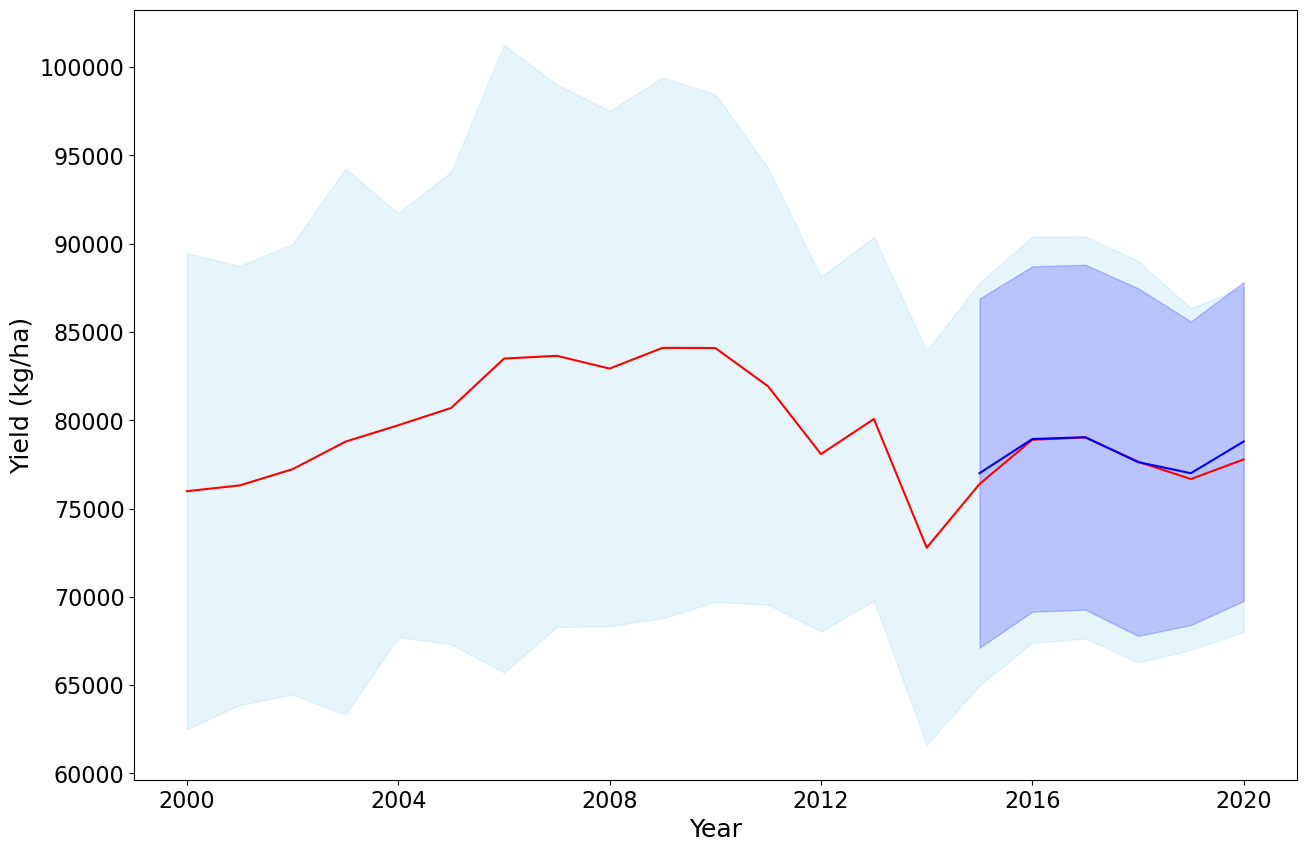

In [37]:
# Plots
plt.figure(figsize = (15,10))
plt.plot(new_data_by_year['Year'], new_data_by_year['Yield'], color = 'red', label='observed')
plt.fill_between(new_data_by_year['Year'], (new_data_by_year['Yield'] + new_data_by_year['st_yield']), 
                 (new_data_by_year['Yield'] - new_data_by_year['st_yield']), alpha = 0.2, color = 'skyblue')
plt.plot(new_predGB_by_year['Year'], new_predGB_by_year['Pred_yieldGB'], color = 'blue', label = 'predicted')
plt.fill_between(new_predGB_by_year['Year'], (new_predGB_by_year['Pred_yieldGB'] + new_predGB_by_year['st_predGB_yield']), 
                (new_predGB_by_year['Pred_yieldGB'] - new_predGB_by_year['st_predGB_yield']), alpha = 0.2, color = 'blue')
plt.ylabel('Yield (kg/ha)', fontsize = 18)
plt.tick_params(labelsize=16)
plt.xlabel('Year', fontsize = 18)
plt.savefig("predicted_yieldGB_over_time.jpeg", dpi = 300)
plt.show()

### Predição para o ano de 2021

In [38]:
# Carregar os dados e separar o x do y
dat_2021= pd.read_csv("tables/aal_data_clean_2021.csv",sep = ';')
x_2021 = dat_2021[['AC','QP','VP' ,'aet_2021', 'soil_2021', 'NDVI_2021','tminx_2021', 'tmmx_2021', 'pr_2021', 'LST_2021', 'npp_2021']]

In [44]:
# Predezir no conjunto de validação e adicionar ao df do yield
pred_gb_2021 = pd.DataFrame(best_grid_gb.predict(x_2021).round(0))

In [62]:
preds_2021 = pd.read_csv("predictions/predicted_2021.csv", sep = ';')
preds_2021['Pred_yieldGB_2021'] = pred_gb_2021
preds_2021.to_csv("preds_2021_PDA_GB.csv", index = False)

In [57]:
preds_2021.dropna(inplace = True)
preds_2021.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514 entries, 0 to 514
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CD_MUN               514 non-null    int64  
 1   NM_MUN               514 non-null    object 
 2   Yield                514 non-null    int64  
 3   Pred_yield_PDA_calc  514 non-null    float64
 4   Pred_yieldGB_2021    514 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 24.1+ KB


In [59]:
# Scores
rmse_pda_2021 = float(format(np.sqrt(mean_squared_error(preds_2021['Yield'], preds_2021['Pred_yield_PDA_calc'])), '.2f'))
print ('\nPerformance')
print('RMSE PDA 2021 = ', rmse_pda_2021, 'g/kg')

rmse_gb_2021 = float(format(np.sqrt(mean_squared_error(preds_2021['Yield'], preds_2021['Pred_yieldGB_2021'])), '.2f'))
print ('\nPerformance')
print('RMSE GB 2021 = ', rmse_gb_2021, 'g/kg')


Performance
RMSE PDA 2021 =  11663.29 g/kg

Performance
RMSE GB 2021 =  6368.17 g/kg


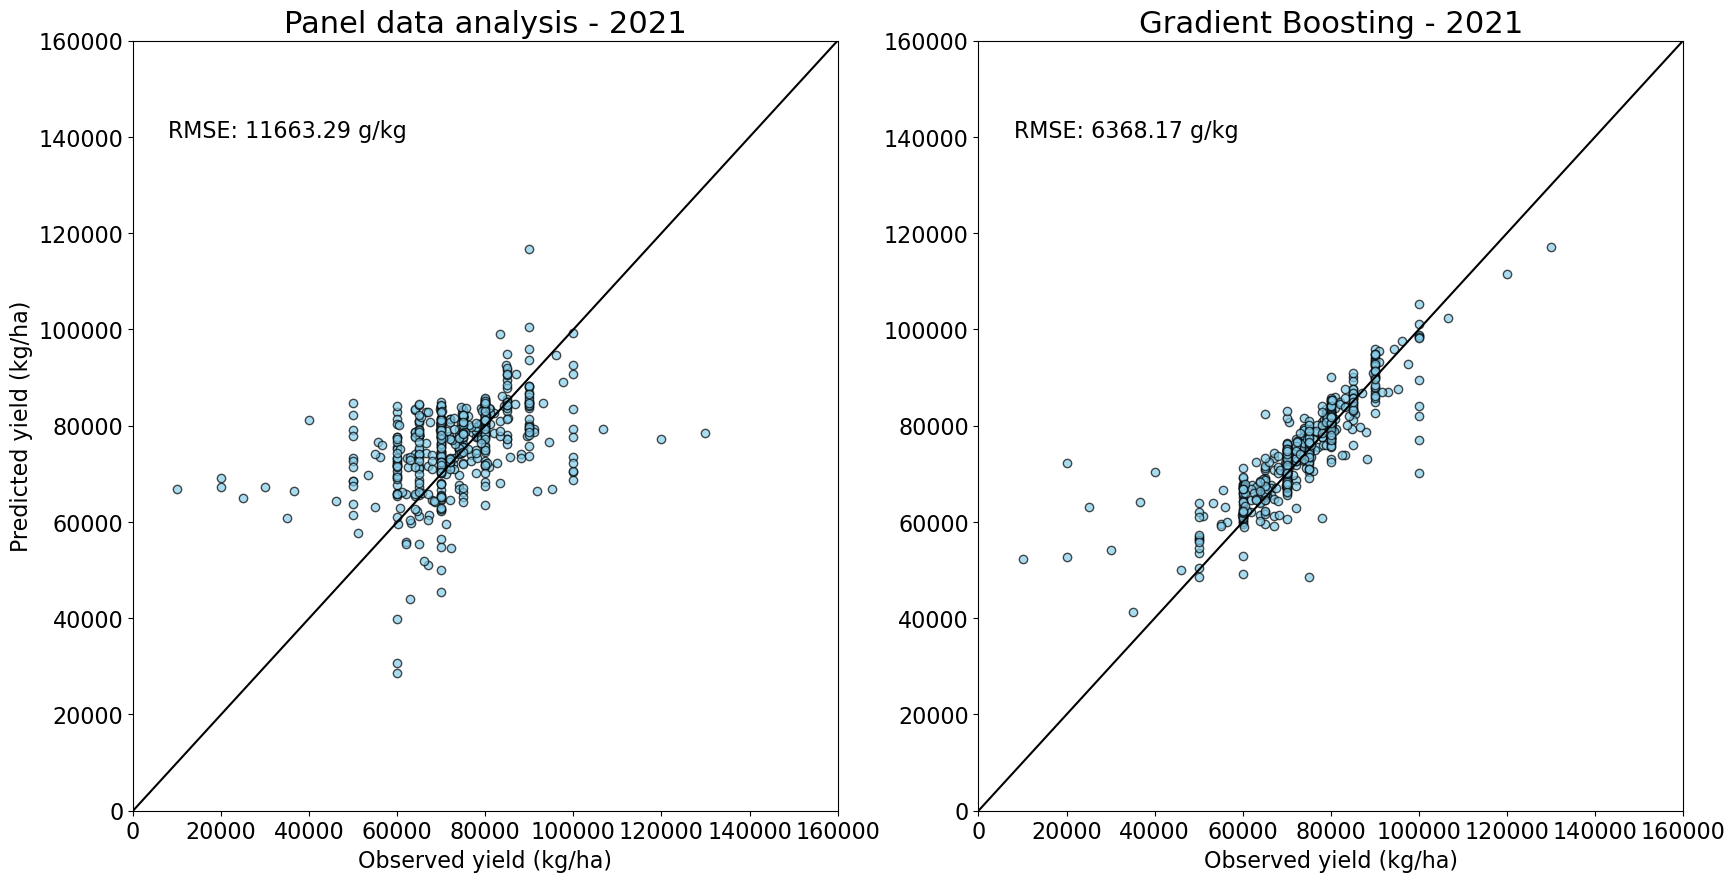

In [61]:
# Plot observed vs predicted
# Plot
plt.figure(figsize=(20, 10))

plt.subplot(1,2,1)
ax = plt.gca()
ax.set_ylim([0, 160000])
ax.set_xlim([0, 160000])
plt.scatter(preds_2021['Yield'], preds_2021['Pred_yield_PDA_calc'], edgecolor='k', facecolor='skyblue', alpha=0.7)
ax.axline((0, 1), slope=1, color='black', label='by slope')
plt.text(8000, 140000,  'RMSE: 11663.29 g/kg', fontsize = 16)
plt.tick_params(labelsize=16)
plt.xlabel('Observed yield (kg/ha)', fontsize=16)
plt.ylabel('Predicted yield (kg/ha)', fontsize=16)
plt.title('Panel data analysis - 2021', fontsize=22)

plt.subplot(1,2,2)
ax = plt.gca()
ax.set_ylim([0, 160000])
ax.set_xlim([0, 160000])
plt.scatter(preds_2021['Yield'], preds_2021['Pred_yieldGB_2021'], edgecolor='k', facecolor='skyblue', alpha=0.7)
ax.axline((0, 1), slope=1, color='black', label='by slope')
plt.text(8000, 140000,  'RMSE: 6368.17 g/kg', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylabel('')
plt.xlabel('Observed yield (kg/ha)', fontsize=16)
plt.title('Gradient Boosting - 2021', fontsize=22)
plt.savefig('pred_vs_obs_2021_gb_pda.jpeg', dpi = 400)
plt.show()

### Hyperparameter tuning - Random Forest

In [43]:
# Parameters of base models
print('\nParameters currently in use in RF:\n')
pprint(base_rf.get_params())


Parameters currently in use in RF:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [65]:
# Number of trees
n_estimators = [10, 20, 50, 10]

# Bootstraping
boostrap = ['True', 'False']

# Depth
max_depth = [2, 4, 6, 8, 12, 15, 20]

# Max features
max_features = ['sqrt', 'log2']

# Max nodes
max_leaf_nodes = [2, 6, 10, 15, 20]

# Max samples
max_samples = [10, 20, 40, 60]

# Samples leaf
min_samples_leaf = [2, 4, 6, 8, 10, 20, 30, 50, 100]

# Samples split
min_samples_split = [2, 4, 8, 12, 20, 50, 80]


# Create the random grid
random_search_rf = {'n_estimators': n_estimators,
                    'bootstrap': boostrap,
                    'max_depth': max_depth,
                    'max_features': max_features,
                    'max_leaf_nodes': max_leaf_nodes,
                    'max_samples': max_samples,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf}
random_search_rf

{'n_estimators': [10, 20, 50, 10],
 'bootstrap': ['True', 'False'],
 'max_depth': [2, 4, 6, 8, 12, 15, 20],
 'max_features': ['sqrt', 'log2'],
 'max_leaf_nodes': [2, 6, 10, 15, 20],
 'max_samples': [10, 20, 40, 60],
 'min_samples_split': [2, 4, 8, 12, 20, 50, 80],
 'min_samples_leaf': [2, 4, 6, 8, 10, 20, 30, 50, 100]}

In [66]:
## Run the model with the hyperparameter tuning
rf_tuning = RandomForestRegressor()

rf_tuning_RSCV = RandomizedSearchCV(estimator = rf_tuning, 
                                    param_distributions = random_search_rf, 
                                    n_iter = 10, 
                                    cv = 10, 
                                    verbose = 2, 
                                    n_jobs = -1)

rf_tuning_RSCV.fit(x_train, y_train)

## Print the best parameters
print('\nThe best parameters are: \n')
pprint(rf_tuning_RSCV.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits

The best parameters are: 

{'bootstrap': 'True',
 'max_depth': 12,
 'max_features': 'log2',
 'max_leaf_nodes': 20,
 'max_samples': 60,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 10}


In [69]:
Parameters currently in use in RF:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

RandomForestRegressor(bootstrap='True', max_depth=12, max_features='log2',
                      max_leaf_nodes=20, max_samples=60, min_samples_leaf=4,
                      min_samples_split=8, n_estimators=10)

In [80]:
## Set cross-validation parameters
rf_grid_params = {'bootstrap' : ['True'], 
                  'n_estimators': [100],
                  'min_samples_split': [2], 
                  'min_samples_leaf': [1], 
                  'max_features': [1]}

rf_grid = RandomForestRegressor()
grid_search_rf = GridSearchCV(estimator = rf_grid, 
                           param_grid = rf_grid_params, 
                           cv = 10, 
                           n_jobs = -1, 
                           verbose = 2)

In [81]:
# Fit grid search
grid_search_rf.fit(x_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': ['True'], 'max_features': [1],
                         'min_samples_leaf': [1], 'min_samples_split': [2],
                         'n_estimators': [100]},
             verbose=2)

In [82]:
# Best parameters
grid_search_rf.best_params_

{'bootstrap': 'True',
 'max_features': 1,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [83]:
best_grid_rf = grid_search_rf.best_estimator_
rf_grid_acc = eval_model(best_grid_rf, best_grid_rf, x_test, y_test)
rf_grid_acc


Performances
RMSE Gradient Boosting =  11449.97 g/kg
RMSE Random Forest =  11449.97 g/kg


In [84]:
y_test

7184     60000.0
2391     85000.0
856     110000.0
1753     80000.0
6146     70000.0
          ...   
5570     81000.0
5611     94183.0
1117     80010.0
6894     51000.0
6477     90000.0
Name: Yield, Length: 1996, dtype: float64

In [85]:
# Predict onto the test set
pred_grid_rf = best_grid_rf.predict(x_test)
pred_grid_rf 

array([76491.33, 83179.91, 79707.33, ..., 83658.36, 74764.67, 82340.24])

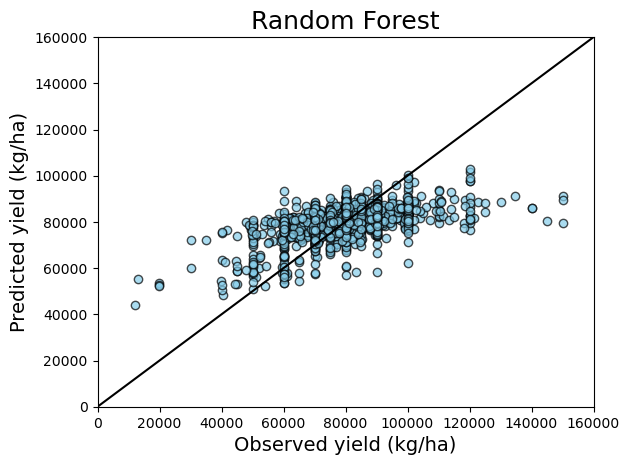

In [86]:
# Plot observed vs predicted
ax = plt.gca()
ax.set_ylim([0, 160000])
ax.set_xlim([0, 160000])
plt.scatter(y_test, pred_grid_rf, edgecolor='k', facecolor='skyblue', alpha=0.7)
ax.axline((0, 1), slope=1, color='black', label='by slope')
plt.ylabel('')
plt.xlabel('Observed yield (kg/ha)', fontsize=14)
plt.ylabel('Predicted yield (kg/ha)', fontsize=14)
plt.title('Random Forest', fontsize=18)
plt.show()

In [87]:
# Get numerical feature importances
importance = list(base_rf.feature_importances_)
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(x_train.columns, importance)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: QP                   Importance: 0.294
Variable: AC                   Importance: 0.234
Variable: NPP                  Importance: 0.073
Variable: AET                  Importance: 0.065
Variable: VP                   Importance: 0.058
Variable: NDVI                 Importance: 0.056
Variable: SOIL                 Importance: 0.055
Variable: LST                  Importance: 0.05
Variable: PR                   Importance: 0.046
Variable: TMIN                 Importance: 0.035
Variable: TMMX                 Importance: 0.035


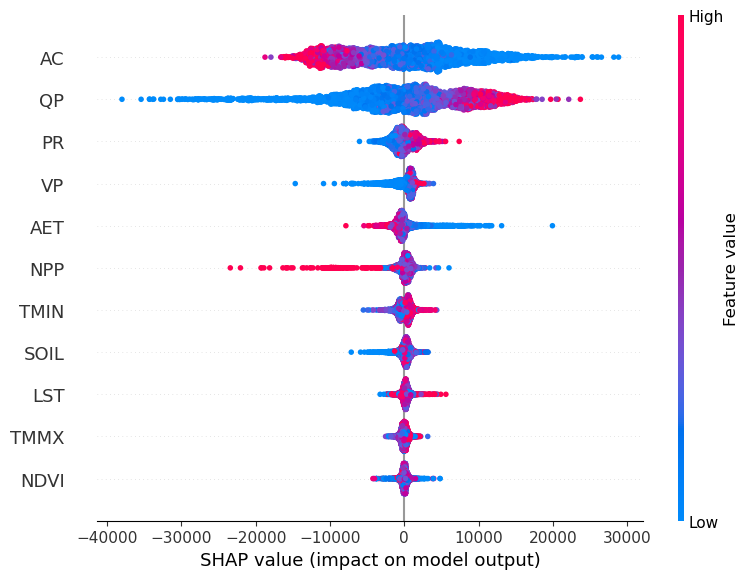

In [88]:
import shap
## Shapley values to explain RF models
explainer_rf = shap.TreeExplainer(base_rf)
shap_values_rf = explainer_rf.shap_values(x_train)
shap.summary_plot(shap_values_rf, features = x_train, feature_names = x_train.columns)

In [89]:
## Plot the contribution of an individual observation. In this case, the number 17
display(x_train.iloc[2])
shap.initjs()
i = 4
shap.force_plot(explainer_rf.expected_value, shap_values_rf[i], features=x_train.loc[i], feature_names=x_train.columns, plot_cmap="PkYg")

AC        5000.000000
QP      400000.000000
VP       20000.000000
AET        772.000000
SOIL       246.028158
NDVI      5838.393885
TMIN       156.000000
TMMX       283.000000
PR          98.000000
LST      15175.000000
NPP       7828.000000
Name: 6191, dtype: float64

In [ ]:
## End